In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/Shareddrives/KOHI_의료영상1팀/

/content/drive/Shareddrives/KOHI_의료영상1팀


In [3]:
ls

 최선/     장미영/                      'Evaluate result'/       Reference/
 이승아/   양수진/                      'External Validation'/   Training_Data/
 이선호/   발표자료/                    '실시간 회의록.gdoc'     wandb/
 회의록/  '10 19 화요일 회의내용.gdoc'   history/
 이동규/   Data/                         mask/


In [4]:
import os
from tqdm import tqdm
import glob

In [5]:
image_path = 'Training_Data/image'
label_path = 'Training_Data/line_label'
predict_path = './Evaluate result/PadChest/mask'

output_name_list = os.listdir(predict_path)

# 영상 불러오기



In [6]:
len(output_name_list)

232

In [7]:
dataset = []

for name in tqdm(output_name_list):
  if os.path.isfile(os.path.join(label_path, name)):
    dataset.append({'name':name,
                    'image_path':os.path.join(image_path, name),
                    'predict_path':os.path.join(predict_path, name),
                    'label_path':os.path.join(label_path, name)})

100%|██████████| 232/232 [00:00<00:00, 3582.80it/s]


In [8]:
dataset

[{'image_path': 'Training_Data/image/216840111366964012558082906712009301094710721_00-081-011.png',
  'label_path': 'Training_Data/line_label/216840111366964012558082906712009301094710721_00-081-011.png',
  'name': '216840111366964012558082906712009301094710721_00-081-011.png',
  'predict_path': './Evaluate result/PadChest/mask/216840111366964012558082906712009301094710721_00-081-011.png'},
 {'image_path': 'Training_Data/image/216840111366964012558082906712009314133351437_00-109-060.png',
  'label_path': 'Training_Data/line_label/216840111366964012558082906712009314133351437_00-109-060.png',
  'name': '216840111366964012558082906712009314133351437_00-109-060.png',
  'predict_path': './Evaluate result/PadChest/mask/216840111366964012558082906712009314133351437_00-109-060.png'},
 {'image_path': 'Training_Data/image/216840111366964012487858717522009287121738850_00-081-067.png',
  'label_path': 'Training_Data/line_label/216840111366964012487858717522009287121738850_00-081-067.png',
  'name

# Erosion

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from skimage.morphology import skeletonize, thin
from skimage import data
from skimage.util import invert

# Skeletonize

In [ ]:
for data in tqdm(dataset):
  file_name = data['name']
  image = cv.imread(data['image_path'])

  origin_output = cv.imread(data['predict_path']).astype(np.float32)
  origin_output = cv.resize(origin_output, dsize=(256, 256), interpolation=cv.INTER_AREA)
  
  # Skeletonizing Image
  result_skeletonizing = skeletonize((origin_output/255))
  # result_skeletonizing = cv.cvtColor(result_skeletonizing, cv.COLOR_BGR2GRAY) 

  plt.figure(figsize=(21, 7))  
  plt.subplot(131)
  plt.imshow(image, cmap='gray')
  plt.title('label(ground truth)')

  plt.subplot(132)
  plt.imshow(origin_output, cmap='gray')
  plt.title('prediction_mask')

  plt.subplot(133)
  plt.imshow(result_skeletonizing, cmap='gray')
  plt.title('skeletonizing')
  
  plt.show()


In [ ]:
# Thinning Process
def line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return int(x), int(y)

def detect(image):
    # some preprocessing
    # image = np.float32(image)

    image = cv.blur(image, (5, 5))
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image = image.astype(np.uint8)
    thin = cv.ximgproc.thinning(image, 0)

    # thin image to find clear contours
    
    thin = thin.astype(np.uint8)
    thin = cv.ximgproc.thinning(thin, thinningType=cv.ximgproc.THINNING_GUOHALL)
    
    # dind contours
    cnts = cv.findContours(thin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv.contourArea)

    # draw line contours
    cv.drawContours(image, [c], -1, (36, 255, 12), 2)

    return image


# Do Opening, Skeletonize, and Save - Plots

In [9]:
result_dir = './이승아/result/PostProcessing/EfficientNet-V2'

In [ ]:
!pip install plantcv
!pip install skan

In [10]:
from skan import draw
from plantcv import plantcv as pcv

In [20]:
pip uninstall -y opencv-contrib-python opencv-python

Found existing installation: opencv-contrib-python 4.5.4.58
Uninstalling opencv-contrib-python-4.5.4.58:
  Successfully uninstalled opencv-contrib-python-4.5.4.58
Found existing installation: opencv-python 3.4.16.57
Uninstalling opencv-python-3.4.16.57:
  Successfully uninstalled opencv-python-3.4.16.57


In [21]:
pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.5.4.58-cp37-cp37m-manylinux2014_x86_64.whl (66.5 MB)


In [17]:
from cv2.ximgproc import thinning

def remove_horizontal_line(output):
  line_kernel = np.zeros((7, 7),dtype=np.uint8)
  line_kernel[3,...]=1
  x=cv.morphologyEx(output, cv.MORPH_OPEN, line_kernel ,iterations=1)
  _output= output - x

  return _output 

  0%|          | 0/232 [00:00<?, ?it/s]


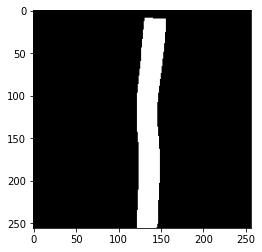

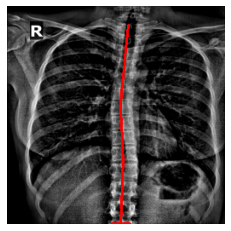

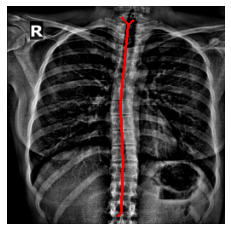

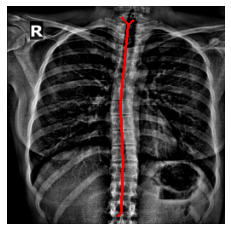

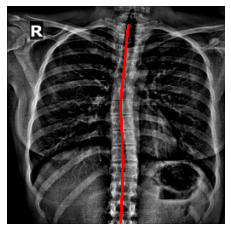

In [36]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

from skimage.morphology import skeletonize, thin
from skimage import data
from skimage.util import invert

from skan import Skeleton, summarize
import imageio as io
from cv2.ximgproc import thinning

for data in tqdm(dataset):
  file_name = data['name']
  image = cv.imread(data['image_path'])
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.resize(image, (256,256), interpolation = cv.INTER_AREA)

  label = cv.imread(data['label_path'])
  label = cv.cvtColor(label, cv.COLOR_BGR2GRAY) 

  predicted_mask = cv.imread(data['predict_path']).astype(np.float32)
  # predicted_mask = cv.cvtColor(predicted_mask, cv.COLOR_BGR2GRAY) 
  
  # # Opening Image
  kernel = np.ones((9, 9), np.uint8)
  result_opening = cv.morphologyEx(predicted_mask, cv.MORPH_OPEN, kernel)
  result_opening = cv.cvtColor(result_opening, cv.COLOR_BGR2GRAY)
  plt.imshow(result_opening, cmap='gray')

  # Thining Image
  result_thinning = thinning(result_opening.astype('uint8'))
  draw.overlay_skeleton_2d(image, result_thinning, dilate=1)
  
  result_skeletonizing = skeletonize((result_opening/255))
  draw.overlay_skeleton_2d(image, result_skeletonizing, dilate=1)
  
  pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skel_img=result_skeletonizing.astype('uint8'),)
  draw.overlay_skeleton_2d(image, pruned_skeleton, dilate=1)

  # Remove horizontal_line
  result_thinning = remove_horizontal_line(result_thinning)

  # pruned_skeleton, segmented_img, segment_objects = pcv.morphology.prune(skel_img=result_thinning,)

  draw.overlay_skeleton_2d(image, result_thinning, dilate=1)
  break

  # plt.savefig(os.path.join(result_dir, f'{file_name}.png'), pad_inches=0.1)
  # plt.close()



# Save to Training_data/Erosion

In [ ]:
result_dir = './Evaluate result/PadChest/line/256'

In [ ]:
skeleton_list = []

def get_overlay_image(input, output):

  return cv.addWeighted(np.array(input),0.4,np.array(output),0.3,0)

count = 0
for data in tqdm(dataset):
  file_name = data['name']
  image = cv.imread(data['image_path'])
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  h,w = image.shape

  label = cv.imread(data['label_path'])
  label = cv.cvtColor(label, cv.COLOR_BGR2GRAY) 

  predicted_mask = cv.imread(data['predict_path']).astype(np.float32)
  # predicted_mask = cv.cvtColor(predicted_mask, cv.COLOR_BGR2GRAY) 
  
  # # Opening Image
  kernel = np.ones((9, 9), np.uint8)
  result_opening = cv.morphologyEx(predicted_mask, cv.MORPH_OPEN, kernel)

  # Skeletonizing Image
  result_skeletonizing = skeletonize((result_opening/255))
  result_skeletonizing = cv.cvtColor(result_skeletonizing, cv.COLOR_BGR2GRAY) 
  
  # result_skeletonizing = cv.resize(result_skeletonizing, (w, h), interpolation = cv.INTER_AREA)
  cv.imwrite(os.path.join(result_dir, f'{file_name}'), result_skeletonizing)


100%|██████████| 232/232 [00:34<00:00,  6.75it/s]


# line smooth하게

In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

result_path = './Training_Data/erosion-origin size'

result_dir = './이승아/result/PostProcessing/Smoothing'
erosion_result = os.listdir(result_path)

In [ ]:
import scipy
import imutils
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

def fit_curve(image):
  contours, _ = cv.findContours(image,0, cv.CHAIN_APPROX_NONE)
  arch = contours[0]
  x,y = arch[...,0].squeeze(), arch[...,1].squeeze()
  inds = y.argsort()
  y=y[inds]
  x=x[inds]
  xx, yy = x[0::15], y[0::15] # <- sample every 15th element to see that the interpolate really works

  spline_fit_curve = scipy.interpolate.splrep(yy, xx, s=100)
  ySpl = np.linspace(yy[0], yy[-1], 300, endpoint=True)
  xSpl = scipy.interpolate.splev(ySpl, spline_fit_curve)
  
  image = image.astype(np.uint8)
  
  plt.figure(figsize=(21, 7))  
  plt.subplot(131)
  plt.imshow(image)
  plt.title('skeleton')

  plt.subplot(132)
  plt.scatter(xx,yy)  
  plt.plot(xSpl, ySpl, '-r')
  plt.ylim([image.shape[0],0])
  plt.xlim([0, image.shape[1]])
  plt.title('sampled points')

  plt.subplot(133)
  plt.plot(xSpl, ySpl, '-r')
  plt.ylim([image.shape[0],0])
  plt.xlim([0, image.shape[1]])
  plt.title('interpolate')

  plt.tight_layout()
  plt.savefig(os.path.join(result_dir, f'{file_name}'), pad_inches=0.1)
  plt.close()

for skeleton in tqdm(erosion_result):
  skeleton_path = os.path.join(result_path, skeleton)
  image = cv.imread(skeleton_path)
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  fit_curve(image)

100%|██████████| 233/233 [03:54<00:00,  1.01s/it]


In [ ]:
p